In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt
import scipy.interpolate as sci

In [26]:
# Moose picture from https://www.publicdomainpictures.net/en/view-image.php?image=317077&picture=moose
# License: License: CC0 Public Domain
im = image.imread('moose_1920px.jpg')

(1920, 1920, 3)


In [32]:
cell = np.asarray(im)[:,:,2]

# rescale from 0 - 1, with 1 in barrier and 0 in open channel
cell = (cell-np.min(cell))/(np.max(cell)-np.min(cell))

y = 1-np.arange(cell.shape[0])/cell.shape[0]
x = np.arange(cell.shape[1])/cell.shape[1]

theta = np.linspace(0, 2.1*np.pi, 100)
x_circ = 0.5+0.5*np.cos(theta)
y_circ = 0.5+0.5*np.sin(theta)

[5.00000000e-01 5.33295266e-01 5.66442727e-01 5.99295233e-01
 6.31706946e-01 6.63533982e-01 6.94635053e-01 7.24872096e-01
 7.54110880e-01 7.82221609e-01 8.09079493e-01 8.34565303e-01
 8.58565902e-01 8.80974747e-01 9.01692358e-01 9.20626766e-01
 9.37693918e-01 9.52818047e-01 9.65932015e-01 9.76977605e-01
 9.85905784e-01 9.92676918e-01 9.97260948e-01 9.99637524e-01
 9.99796096e-01 9.97735961e-01 9.93466264e-01 9.87005958e-01
 9.78383724e-01 9.67637836e-01 9.54815998e-01 9.39975129e-01
 9.23181111e-01 9.04508497e-01 8.84040179e-01 8.61867019e-01
 8.38087450e-01 8.12807035e-01 7.86137998e-01 7.58198731e-01
 7.29113261e-01 6.99010705e-01 6.68024697e-01 6.36292788e-01
 6.03955845e-01 5.71157419e-01 5.38043109e-01 5.04759917e-01
 4.71455595e-01 4.38277987e-01 4.05374378e-01 3.72890833e-01
 3.40971554e-01 3.09758239e-01 2.79389449e-01 2.50000000e-01
 2.21720357e-01 1.94676060e-01 1.68987165e-01 1.44767711e-01
 1.22125213e-01 1.01160186e-01 8.19656995e-02 6.46269614e-02
 4.92209425e-02 3.581603

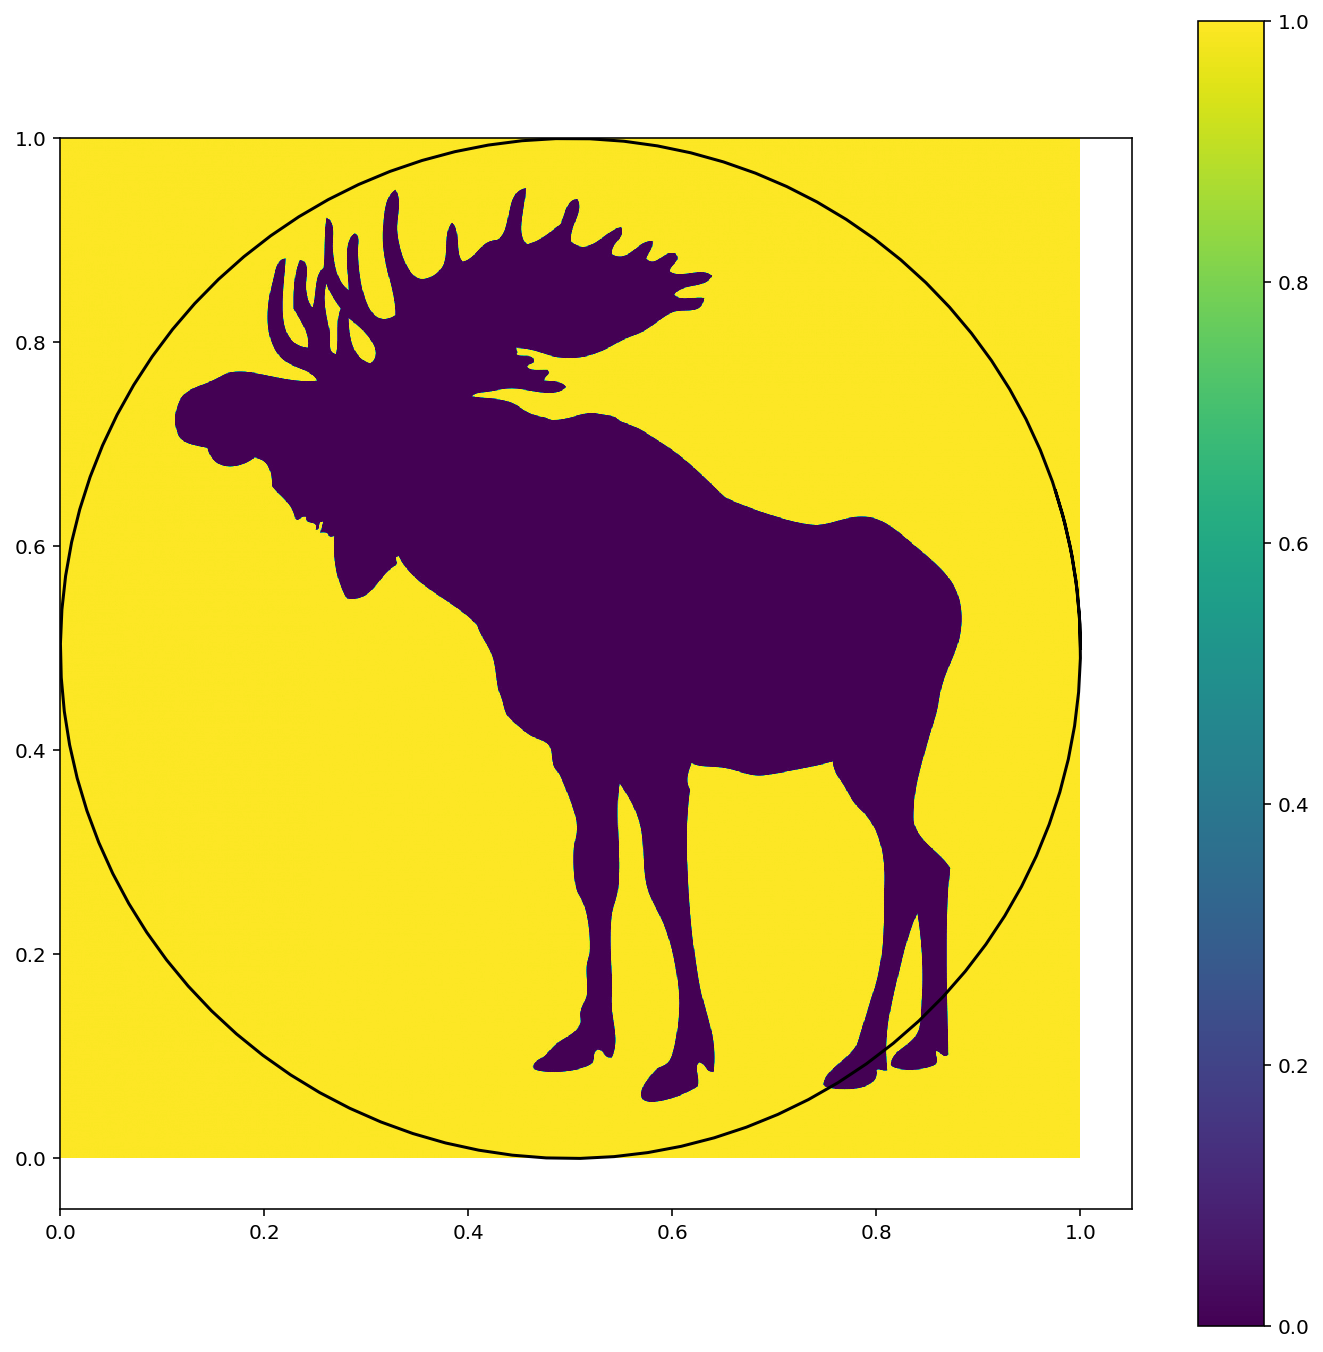

In [34]:
fig, ax = plt.subplots(figsize=[12,12])
mesh = ax.pcolormesh(x, y, cell, shading='auto', vmin=0, vmax=1)
ax.set_aspect(1)
plt.colorbar(mesh)
plt.plot(x_circ, y_circ, c='k')

In [36]:
interp = sci.interp2d(x,y,cell)
#interp = sci.RegularGridInterpolator((x,y), cell.T, method='nearest')

(1920,) (1920,)


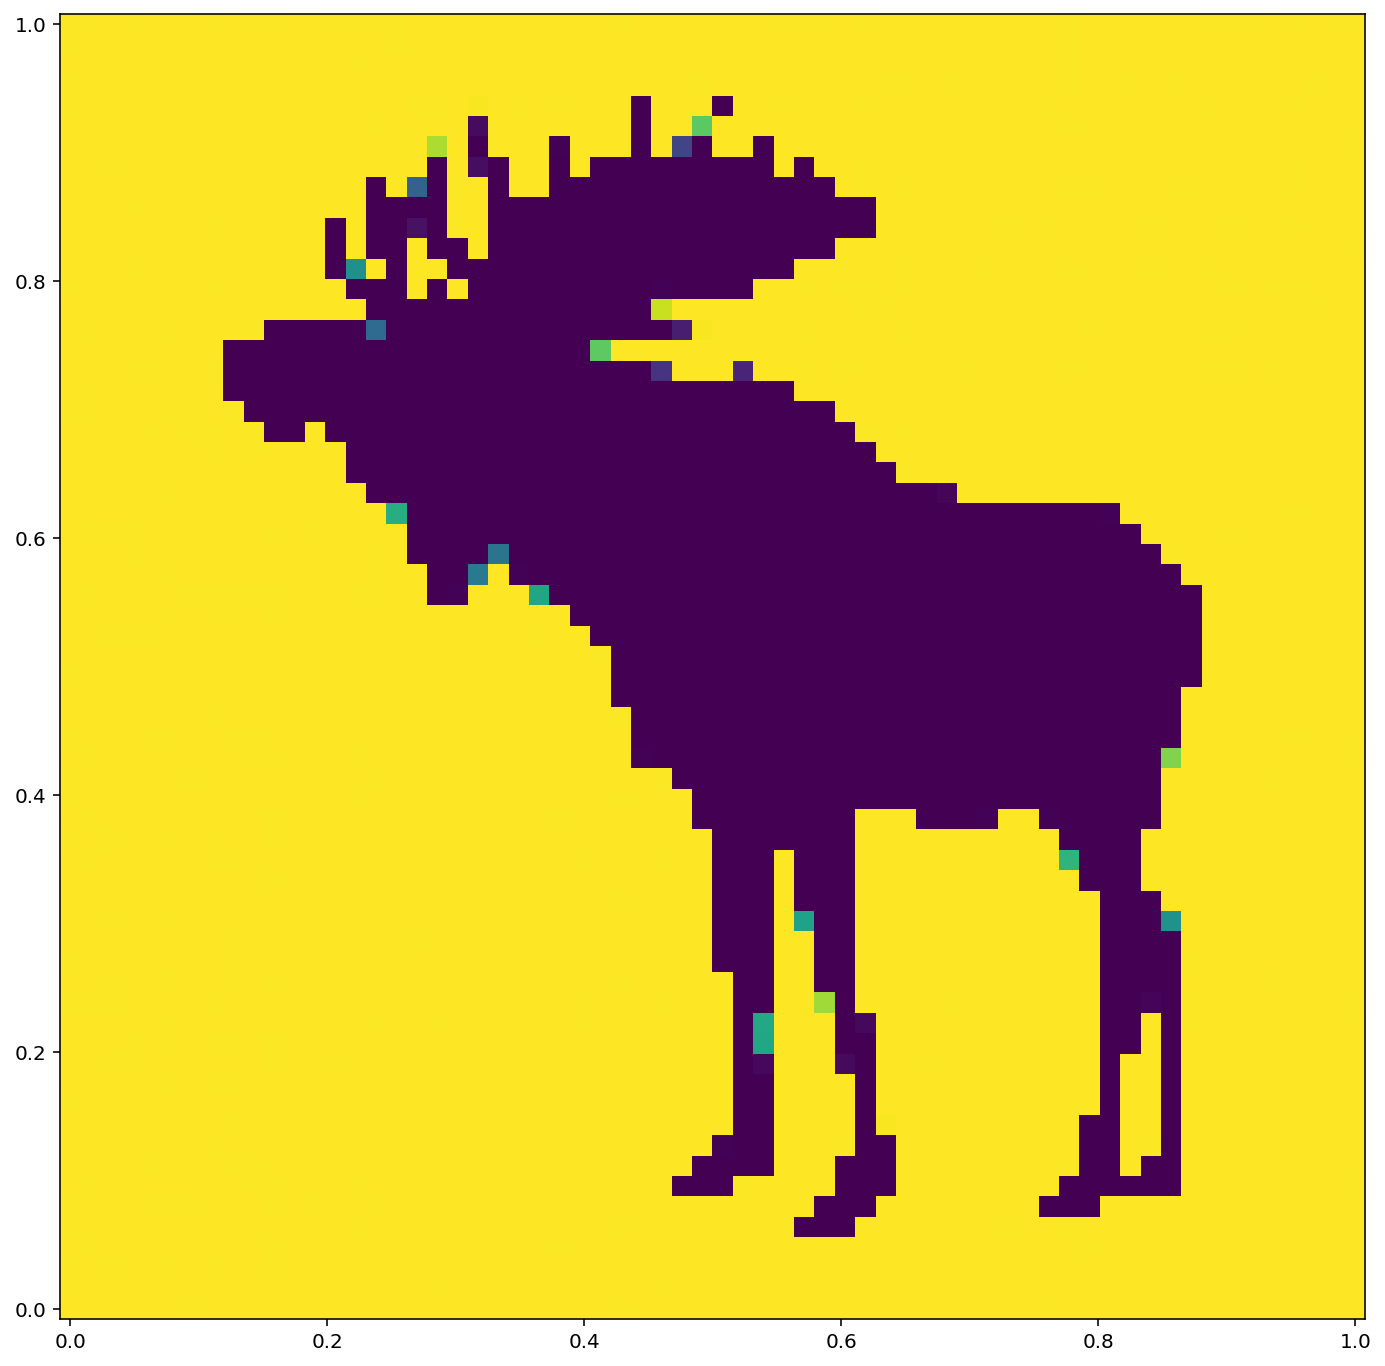

In [39]:
# Coarsen the shape, deliberately
# This lets us use a smooth interpolation to go back to large size but with smooth rather than sharp boundaries for the IBM
# note: this does not need to be a multiple of the original pixel size of the image
print(x.shape, y.shape)
x2 = np.linspace(np.min(x), np.max(x), num=64)
y2 = np.linspace(np.min(y), np.max(y), num=64)
X, Y = np.meshgrid(x2, y2)
Z = interp(x2, y2)

fig, ax = plt.subplots(figsize=[12,12])
ax.pcolormesh(X, Y, Z, shading='auto')
ax.set_aspect(1)

In [40]:
# interpolate the shape to smooth it; this makes a smooth transition at the edges of the IBM.
# note, this doesn't need to be a multiple of the coarsened grid, but I made it so here for convenience.
interp_smooth = sci.interp2d(x2,y2,Z)
x3 = np.linspace(np.min(x), np.max(x), num=512)
y3 = np.linspace(np.min(y), np.max(y), num=512)
z3 = interp_smooth(x3,y3)

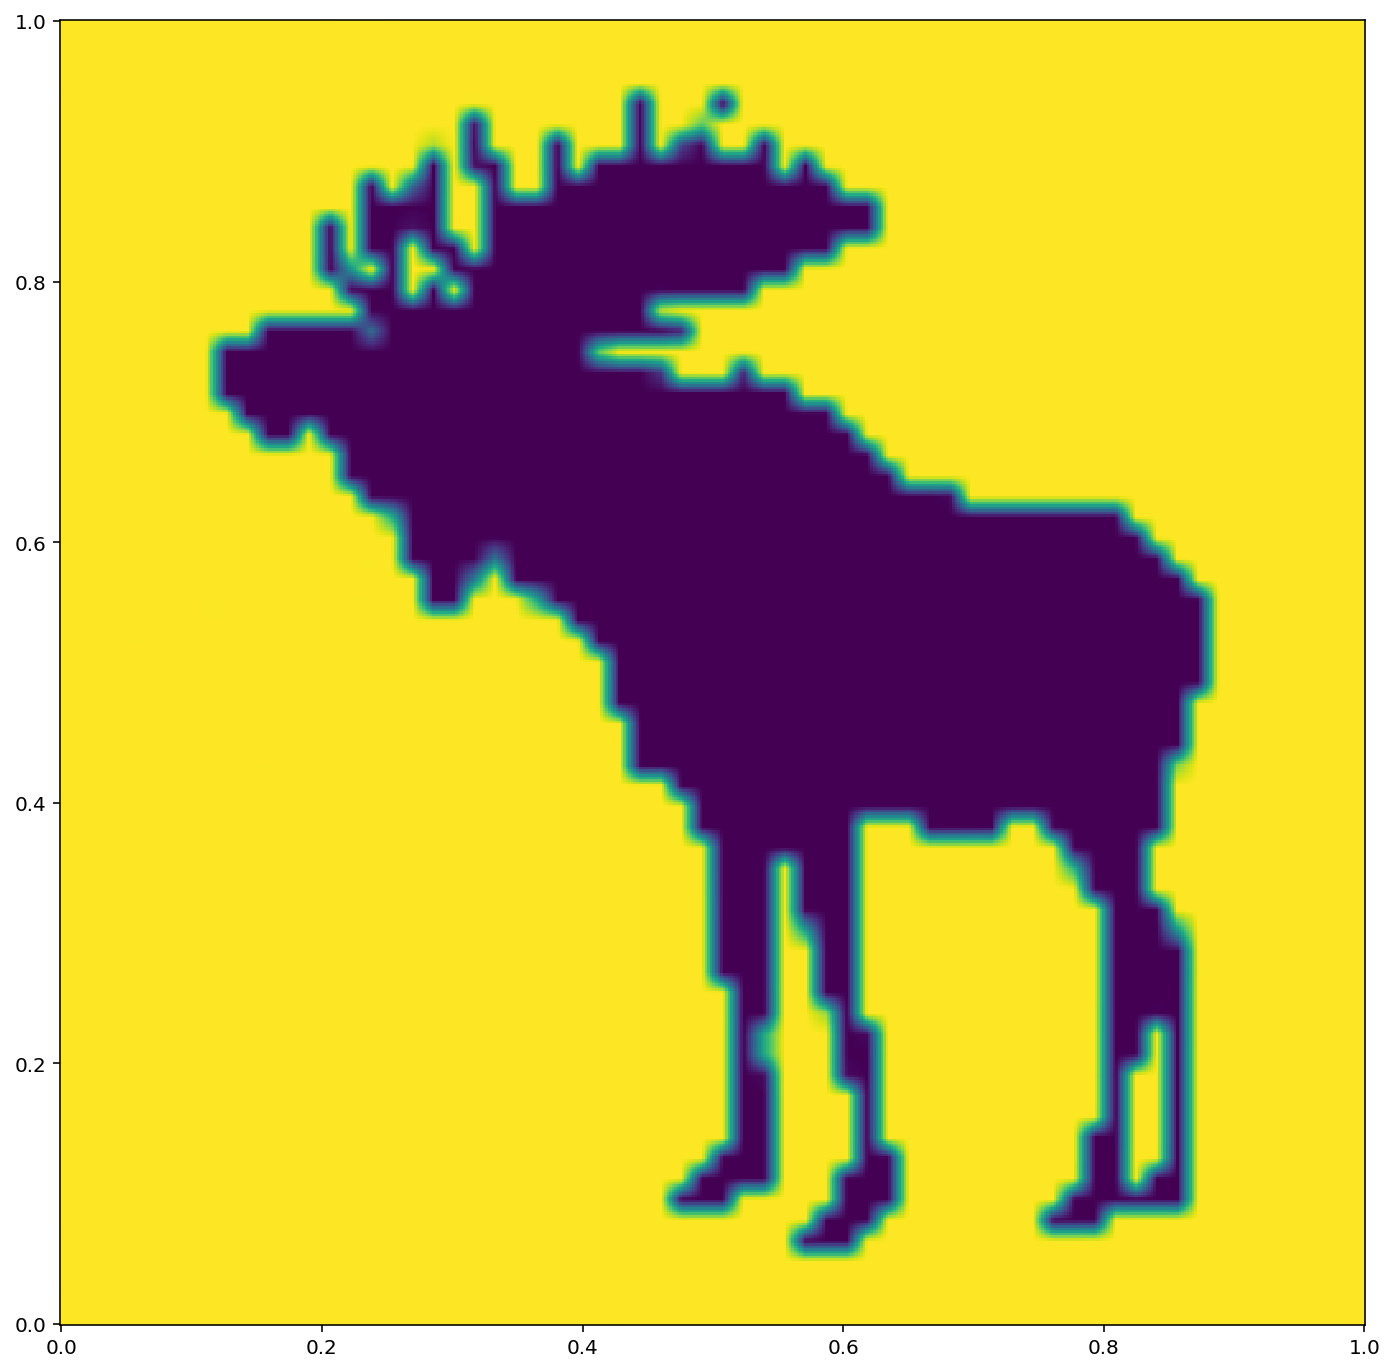

In [41]:
fig, ax = plt.subplots(figsize=[12,12])
ax.pcolormesh(x3, y3, z3, shading='auto',vmax=1, vmin=0)
ax.set_aspect(1)

In [93]:
import dedalus.public as d3
Nphi = 256
Nr = 128
dtype = np.float64
dealias = 3/2

coords = d3.PolarCoordinates('phi', 'r')
dist = d3.Distributor(coords, dtype=dtype)
basis = d3.DiskBasis(coords, shape=(Nphi, Nr), radius=1, dealias=dealias, dtype=dtype, azimuth_library='matrix')

mask_grid = dist.Field(bases=basis)
phi, r = basis.local_grids((dealias, dealias))
#print(phi.squeeze(), r.squeeze())

mask_grid.require_scales(dealias)
for i in range(phi.shape[0]):
    for j in range(r.shape[1]):
        x = (r[0,j]*(np.cos(phi[i,0])) + 1)/2
        y = (r[0,j]*(np.sin(phi[i,0])) + 1)/2
        #print(x,y) - need to rescale from [0,1] to [-1,1]
        mask_grid['g'][i,j] = interp_smooth(x, y)

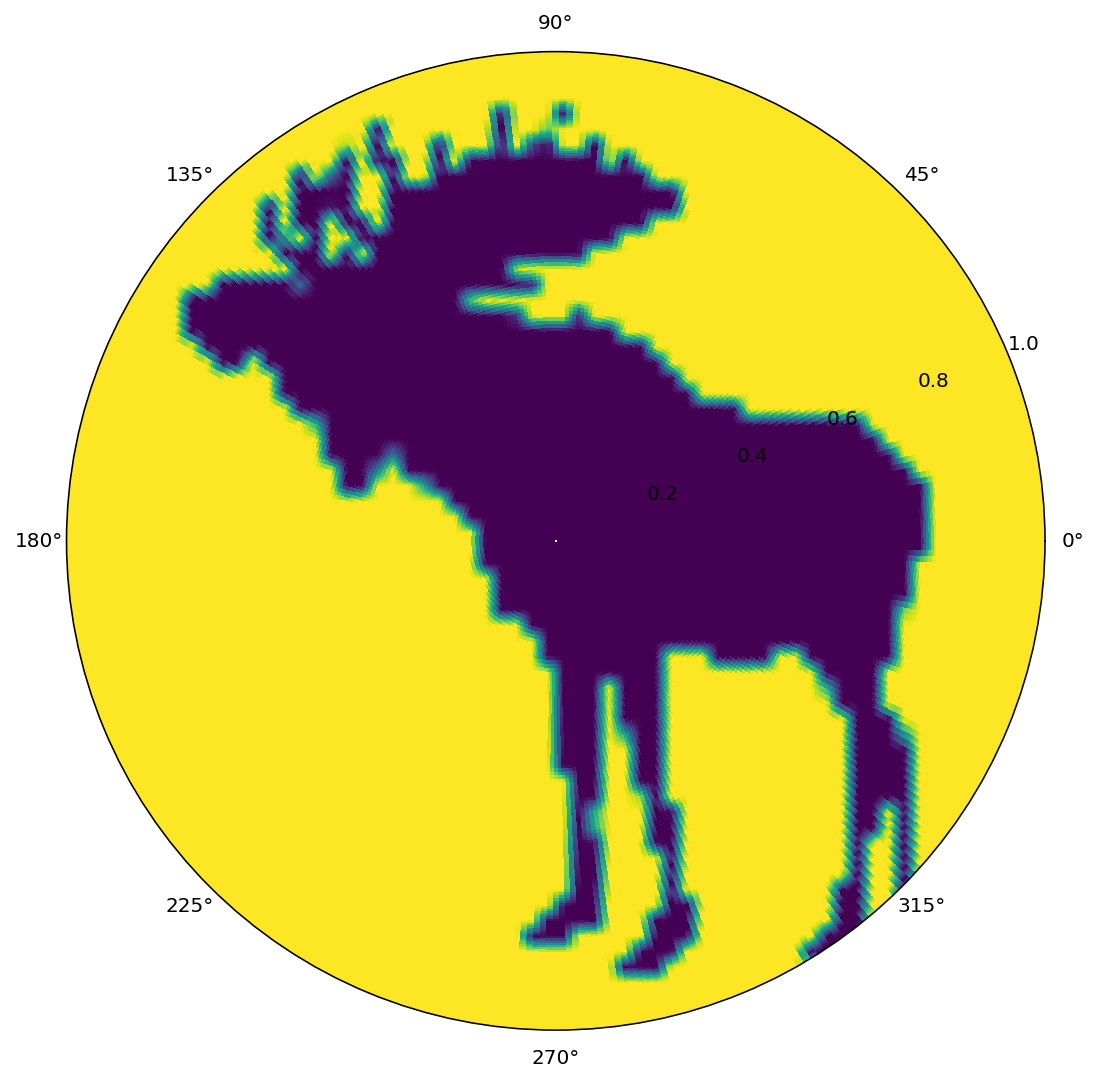

In [94]:
fig = plt.figure(figsize=[9,9])
ax = fig.add_subplot(1,1,1, polar=True)

rr, pp = np.meshgrid(r, phi)
ax.pcolormesh(pp, rr, mask_grid['g'], shading='auto')

In [98]:
import h5py
with h5py.File('masks/moosinesq_{}x{}_de{:.1f}.h5'.format(Nr,Nphi,dealias), 'w') as f:
    f['mask'] = mask_grid['g']
    f['r'] = r
    f['phi'] = phi